# **PROGRAM VERIFIKASI TANDA TANGAN (CNN + OCR)**

In [1]:
!sudo apt-get update
!sudo apt-get install tesseract-ocr
!pip install pytesseract

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,599 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [634 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,305 kB]
Hit:13 htt

In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing import image
from google.colab import drive
from google.colab import files
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import io
import IPython.display as display
import pytesseract
from PIL import Image


In [55]:
# Mount Google Drive
drive.mount('/content/drive')

# Path ke dataset
train_dir = '/content/drive/My Drive/Kaggle/Dataset_Signature_Final'
validation_split = 0.2


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
# Definisi ImageDataGenerator untuk train dan validation
train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

train_generator = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    subset='training'
)

validation_generator = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    subset='validation'
)


Found 240 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [57]:
# Membangun model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [58]:
# Kompilasi model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Pelatihan model
model.fit(train_generator, epochs=10)


Epoch 1/10
12/12 [==============================] - 20s 2s/step - loss: 0.7963 - accuracy: 0.5083
Epoch 2/10
12/12 [==============================] - 16s 1s/step - loss: 0.6926 - accuracy: 0.5125
Epoch 3/10
12/12 [==============================] - 17s 1s/step - loss: 0.6852 - accuracy: 0.5125
Epoch 4/10
12/12 [==============================] - 19s 1s/step - loss: 0.6529 - accuracy: 0.6417
Epoch 5/10
12/12 [==============================] - 17s 1s/step - loss: 0.5999 - accuracy: 0.6292
Epoch 6/10
12/12 [==============================] - 19s 2s/step - loss: 0.5574 - accuracy: 0.6625
Epoch 7/10
12/12 [==============================] - 15s 1s/step - loss: 0.5124 - accuracy: 0.6917
Epoch 8/10
12/12 [==============================] - 15s 1s/step - loss: 0.4926 - accuracy: 0.7208
Epoch 9/10
12/12 [==============================] - 15s 1s/step - loss: 0.4523 - accuracy: 0.7417
Epoch 10/10
12/12 [==============================] - 15s 1s/step - loss: 0.4281 - accuracy: 0.7500


In [59]:
# Fungsi untuk membersihkan gambar dari karakter null byte
def clean_image(image_path):
    img = Image.open(image_path)
    img = img.convert("RGB")

    # Mengubah semua piksel nol menjadi piksel putih (255)
    img_array = np.array(img)
    img_array[img_array == 0] = 255

    # Membuat gambar baru dari array piksel yang telah diubah
    new_img = Image.fromarray(img_array)
    return new_img


In [60]:
# Fungsi untuk melakukan OCR pada gambar
def image_to_text(image_path):
    img = Image.open(image_path)
    img = img.convert("RGB")

    # Menggunakan pytesseract untuk melakukan OCR
    text = pytesseract.image_to_string(img, lang="eng")
    return text


In [61]:
# Fungsi untuk memverifikasi tanda tangan dengan OCR
def verify_signature_with_ocr(image_path):
    img = image.load_img(image_path, target_size=(150, 150))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    prediction = model.predict(img)

    if prediction[0][0] >= 0.5:
        # Gunakan gambar yang telah dibersihkan untuk OCR
        cleaned_image = clean_image(image_path)

        # Simpan gambar yang telah dibersihkan
        cleaned_image_path = 'cleaned_image.jpg'
        cleaned_image.save(cleaned_image_path)

        # Gunakan gambar yang telah dibersihkan untuk OCR
        extracted_text = image_to_text(cleaned_image_path)
        return "Tanda tangan asli", extracted_text
    else:
        return "Tanda tangan palsu", None


Saving ttd.png to ttd (2).png
File yang diunggah: "ttd (2).png" dengan ukuran 8967 bytes


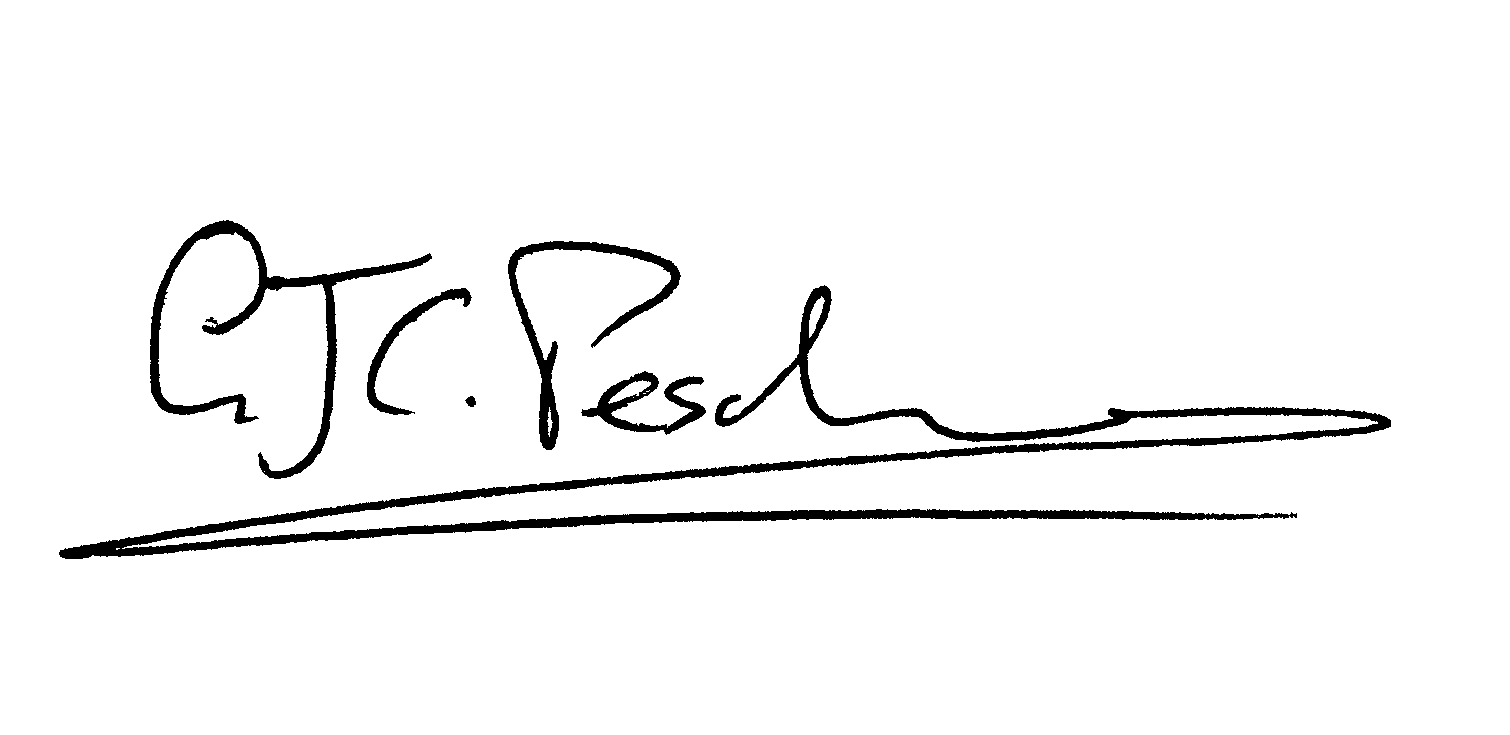

1/1 [==============================] - 0s 115ms/step
Hasil verifikasi: Tanda tangan asli
Teks yang diekstraksi: 


In [62]:
# Mengunggah gambar
uploaded = files.upload()

# Mendapatkan path dari file yang diunggah
for fn in uploaded.keys():
    uploaded_image_path = fn
    print('File yang diunggah: "{name}" dengan ukuran {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

    # Tampilkan gambar yang diunggah
    display.display(display.Image(uploaded_image_path, width=300))

    # Memanggil fungsi untuk verifikasi tanda tangan dengan OCR
    result, extracted_text = verify_signature_with_ocr(uploaded_image_path)
    print("Hasil verifikasi:", result)
    if extracted_text:
        print("Teks yang diekstraksi:", extracted_text)


# **METRIKS PENGUJIAN**

3/3 [==============================] - 1s 313ms/step


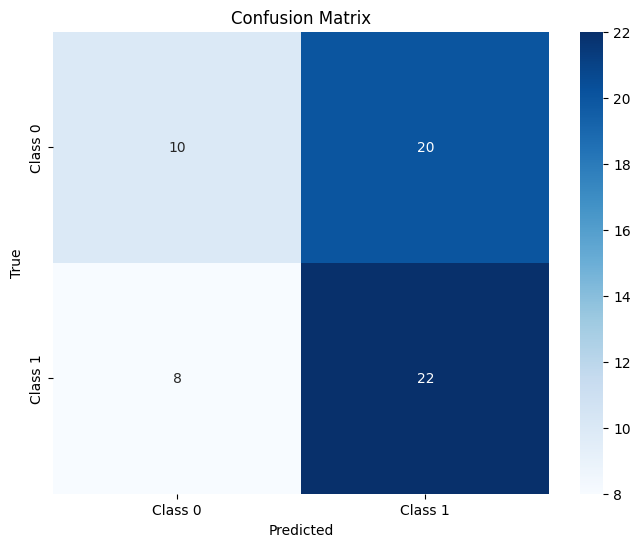

In [67]:
# Evaluasi model menggunakan data validasi
model.evaluate(validation_generator)

# Memprediksi data validasi
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_binary = np.round(y_pred)

# Menghitung metriks evaluasi
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)
roc_auc = roc_auc_score(y_true, y_pred)

# Membuat matriks pengujian
conf_matrix = confusion_matrix(y_true, y_pred_binary)

# Menampilkan matriks pengujian sebagai heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [68]:
# Menampilkan metriks evaluasi dengan 2 digit di belakang koma
print("\nMetriks Evaluasi pada Data Validasi:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")



Metriks Evaluasi pada Data Validasi:
Accuracy: 0.53
Precision: 0.52
Recall: 0.73
F1-Score: 0.61
ROC AUC: 0.57
